In [2]:
from construct import *

format_word = Struct(
    "daq_major" / Byte,
    "daq_minor" / Byte,
    "data_format_major" / Byte,
    "data_format_minor" / Byte
)

two_word_file_header = Struct(
    "endian_indicator" / Int32ul,
    "data_format" / format_word
)

detector_hdr = Struct(
    "header_number" / Int32ul,
    "config_record_len" / Int32ul,
    "repeat_value" / Computed(
        lambda this: (this.config_record_len // 72) + (this.config_record_len // 144)
    )
)

charge_config_header = Struct(
    "charge_config_len" / Int32ul,
    "detector_code" / Int32sl,
    "tower_number" / Int32sl,
    "channel_post_amp" / Int32sl,
    "channel_bias" / Int32sl,
    "rtf_offset" / Int32sl,
    "delta_t" / Int32sl,
    "trigger_time" / Int32sl,
    "trace_len" / Int32sl
)

phonon_config_header = Struct(
    "phonon_config_len" / Int32ul,
    "detector_code" / Int32sl,
    "tower_number" / Int32sl,
    "post_amp_gain" / Int32sl,
    "qet_bias" / Int32sl,
    "squid_bias" / Int32sl,
    "squid_lockpoint" / Int32sl,
    "rtf_offset" / Int32sl,
    "variable_gain" / Int32sl,
    "delta_t" / Int32sl,
    "trigger_time" / Int32sl,
    "trace_len" / Int32sl
)

header_list = Struct(
    "header_number" / Int32ul,
    "charge_config" / If(
        lambda this: this.header_number == 0x10002,
        charge_config_header
    ),
    "phonon_config" / If(
        lambda this: this.header_number == 0x10001,
        phonon_config_header
    )
)

event_header = Struct(
    "event_header_word" / Int32ul,
    "event_size" / Int32ul,
    "event_identifier" / Computed(
        lambda this: (this.event_header_word >> 16) & 0xFFFF
    ),
    # 0x0: Raw, 0x1: Processed, 0x2: Monte Carlo
    "event_class" / Computed(
        lambda this: (this.event_header_word >> 8) & 0xF
    ),
    # 0x0: Per Trigger, 0x1: Occasional, 0x2: Begin File Series, 0x3: Begin File
    # 0x4: End File, 0x5: End File Series, 0x6: Per Trigger w/ Detectors that Cross Threshold
    "event_category" / Computed(
        lambda this: (this.event_header_word >> 12) & 0xF
    ),
    # 0x0: Wimp Search, 0x1: 60Co Calibration, 0x2: 60Co Low Energy Calibration,
    # 0x3: Neutron Calibration, 0x4: Random Triggers, 0x5: Pulse Triggers
    # 0x6: Test, 0x7: Data Monitering Event, 0x8: 137Cs Calibration
    "event_type" / Computed(
        lambda this: (this.event_header_word & 0xFF)
    )
)

administrative_record = Struct(
    "admin_header" / Int32ul,
    "admin_len" / Int32ul,
    "series_number_1" / Int32ul,
    "series_number_2" / Int32ul,
    "event_number_in_series" / Int32ul,
    "seconds_from_epoch" / Int32ul,
    # Epoch defined as Jan 1st 1904 for SUF (MAC Artifact)
    # Epoch defined as Jan 1st 1970 for Soudan
    "time_from_last_event" / Int32ul,
    "live_time_from_last_event" / Int32ul
)

trace_record = Struct(
    "trace_header" / Int32ul,
    "trace_len" / Int32ul,
    "trace_bookkeeping_header" / Int32ul,
    "bookkeeping_len" / Int32ul,
    "digitizer_base_address" / Int32ul,
    "digitizer_channel" / Int32ul,
    "detector_code" / Int32ul,
    "timebase_header" / Int32ul,
    "timebase_len" / Int32ul,
    "t0_in_ns" / Int32ul,
    "delta_t_ns" / Int32ul,
    "num_of_points" / Int32ul,
    "second_trace_header" / Int32ul,
    "num_samples" / Int32ul
    # Should be a power of two (1024, 2048, etc)
)

data_sample = Struct(
    "data_selection" / Int32ul,
    "sample_a" / Computed(
        lambda this: (this.data_selection >> 16) & 0xFFFF
    ),
    "sample_b" / Computed(
        lambda this: (this.data_selection & 0xFFFF)
    )
)


trace_data = Struct(
    "trace_rcrds" / trace_record,
    "sample_data" / Array(
        this.trace_rcrds.num_samples // 2,
        data_sample
    )
)

soudan_history_buffer = Struct(
    "history_buffer_header" / Int32ul,
    "history_buffer_len" / Int32ul,
    "num_time_nvt" / Int32ul,
    "time_nvt" / Array(
        this.num_time_nvt,
        Int32ul
    ),
    "num_veto_mask_words" / Int32ul,
    "time_n_minus_veto_mask" / Array(
        this.num_time_nvt * this.num_veto_mask_words,
        Int32ul
    ),
    "num_trigger_times" / Int32ul,
    "trigger_times" / Array(
        this.num_trigger_times,
        Int32ul
    ),
    "num_trigger_mask_words" / Int32ul,
    "trig_times_minus_trig_mask" / Array(
        this.num_trigger_times * this.num_trigger_mask_words,
        Int32ul
    )
)

trigger_record = Struct(
    "trigger_header" / Int32ul,
    "trigger_len" / Int32ul,
    "trigger_time" / Int32ul,
    "individual_trigger_masks" / Array(
        6,
        Int32ul
    )
)

tlb_trigger_mask_record = Struct(
    "tlb_mask_header" / Int32ul,
    "tlb_len" / Int32ul,
    "tower_mask" / Array(
        6,
        Int32ul
    )
)

gps_data = Struct(
    "tlb_mask_header" / Int32ul,
    "length" / Int32ul,
    "gps_year_day" / If(
        this.length > 0,
        Int32ul
    ),
    "gps_status_hour_minute_second" / If(
        this.length > 0,
        Int32ul
    ),
    "gps_microsecs_from_gps_second" / If(
        this.length > 0,
        Int32ul
    )
)

detector_trigger_threshold_data = Struct(
    "threshold_header" / Int32ul,
    "len_to_next_header" / Int32ul,
    "minimum_voltage_level" / Int32ul,
    "maximum_voltage_level" / Int32ul,
    "dynamic_range" / Int32ul,
    "tower_number" / Int32ul,
    "detector_codes" / Array(
        6,
        Int32ul
    ),
    "operations_codes" / Array(
        9,
        Int32ul
    ),
    "adc_values" / Array(
        54,
        Int32ul
    )
)

detector_trigger_rates = Struct(
    "detector_trigger_header" / Int32ul,
    "len_to_next_header" / Int32ul,
    "clocking_interval" / Int32ul,
    "tower_number" / Int32ul,
    "detector_codes" / Array(
        6,
        Int32ul
    ),
    "j_codes" / Array(
        5,
        Int32ul
    ),
    "counter_values" / Array(
        30,
        Int32ul
    )
)

veto_trigger_rates = Struct(
    "veto_trigger_header" / Int32ul,
    "len_to_next_header" / Int32ul,
    "clocking_interval" / Int32ul,
    "num_entries" / Int32ul,
    "detector_code" / Array(
        this.num_entries,
        Int32ul
    ),
    "counter_value_det_code" / Array(
        this.num_entries,
        Int32ul
    )
)


logical_records = Struct(
    "event_hdr" / Peek(Int32ul),  # Peek to check first
    "next_section" / Struct(
        "next_header" / Peek(Int32ul),  # Peek without consuming
        "section" / Switch(
            lambda this: (
                this.next_header if ((this.next_header >> 16) != 0xA980) 
                else 0xA980  # Use 0xA980 as identifier for event_header
            ),
            {
                0xA980: event_header,
                0x00000002: administrative_record,
                0x00000011: trace_data,
                0x00000021: soudan_history_buffer,
                0x00000060: gps_data,
                0x00000080: trigger_record,
                0x00000081: tlb_trigger_mask_record,
                0x00000022: detector_trigger_rates,
                0x00000031: veto_trigger_rates,
            }
        )
    )
)

In [3]:
import h5py

def get_detector_code_info(detector_code):
    """
    Detector codes come in the form xxxyyyzzz

    xxx - detector type (0-999)

    yyy - detector number (0-999)

    zzz - channel number (0-999)

    Detector types and channel numbers should not exceed two digits.
    """
    detector_type_dictionary = [
        # Channel numbers gives charge or phonon
        {'ID': 1,  'Det Type': 'Blip', 'Charge': [1,2], 'Phonon': [3,4]},
        {'ID': 2,  'Det Type': 'Flip', 'Charge': [0,1], 'Phonon': [2,3,4,5]},
        {'ID': 3,  'Det Type': 'Veto', 'Charge': 'None', 'Phonon': 'None'},
        {'ID': 4,  'Det Type': 'ZIP', 'Charge': [0,1], 'Phonon': [2,3,4,5]},
        {'ID': 5,  'Det Type': 'mercedes ZIP', 'Charge': [0,1], 'Phonon': [2,3,4,5]},
        {'ID': 6,  'Det Type': 'endcap (class I)', 'Charge': [0,1], 'Phonon': [2,3,4,5]},
        {'ID': 7,  'Det Type': 'endcap (class II)', 'Charge': [0], 'Phonon': [1,2]},
        {'ID': 10, 'Det Type': 'iZIP (class I)', 'Charge': [0,1,6,7], 'Phonon': [2,3,4,5,8,9,10,11]},
        {'ID': 11, 'Det Type': 'iZIP (class II)', 'Charge': [0,1,6,7], 'Phonon': [2,3,4,5,8,9,10,11]}
    ]

    if len(str(detector_code)) == 8:
        detector_type = int(str(detector_code)[:2])
    else:
        detector_type = int(str(detector_code)[:1])
    detector_number = int(str(detector_code)[-6:-3]) # Not used here, returned for utility
    channel_number = int(str(detector_code)[-3:])

    try:
        detector_info = next((d for d in detector_type_dictionary if d['ID'] == detector_type))
    except:
        #print(f'Error on detector code: {detector_code}\nDetector type not found.')
        det_type = 'Error'
        charge = False
        phonon = False
        veto = False
        error = True
    
    try:
        det_type = detector_info['Det Type']
        # Reverse lookup for the channel number
        if isinstance(detector_info['Charge'], list) and channel_number in detector_info['Charge']:
            charge = True
            phonon = False
            veto = False
            error = False
        elif isinstance(detector_info['Phonon'], list) and channel_number in detector_info['Phonon']:
            charge = False
            phonon = True
            veto = False
            error = False
        elif detector_info['Det Type'] == 'Veto':
            charge = False
            phonon = False
            veto = True
            error = False
        else:
            charge = False
            phonon = False
            veto = False
            error = True
    except:
        det_type = 'Error'
        charge = False
        phonon = False
        veto = False
        error = True

    return det_type, charge, phonon, veto, error, detector_number

# Test detector code
type, charge, phonon, veto, error, detector_number = get_detector_code_info(3555001)
print(f'Type: {type}, Charge: {charge}, Phonon: {phonon}, Veto: {veto}, Error: {error}, Detector Number: {detector_number}')

# Print structure function to inspect groups mid processing
def print_structure(name, obj):
    if isinstance(obj, h5py.Group):
        print(f'Group: {name}')
    elif isinstance(obj, h5py.Dataset):
        print(f"Dataset: {name}, Shape: {obj.shape}, Data type: {obj.dtype}")
        # Print the dataset values (for small datasets)
        data = obj[()]
        print(f"Values: {data}")

soudan = Struct(
    "file_hdr" / two_word_file_header,
    "detector_hdr" / detector_hdr,
    "hdrs" / Array(
        this._root.detector_hdr.repeat_value,
        header_list
    ),
    "logical_rcrds" / GreedyRange(logical_records)
)

# Parsing instructions to create smaller files faster
test = Struct(
    "file_hdr" / two_word_file_header,
    "detector_hdr" / detector_hdr,
    "hdrs" / Array(
        this._root.detector_hdr.repeat_value,
        header_list
    ),
    "logical_rcrds" / Array(
        1500,
        logical_records
    )
)

Type: Veto, Charge: False, Phonon: False, Veto: True, Error: False, Detector Number: 555


In [4]:
def parse_file(input_path, output_path, use_test_parse=True):
    if use_test_parse:
        print(f'Parsing {input_path}...')
    with open(input_path, 'rb') as input_f:
        raw_data = input_f.read()
        # Switch between soudan and test for different amounts of parsing
        if use_test_parse:
            parsed_data = test.parse(raw_data)
        else:
            parsed_data = soudan.parse(raw_data)

    with h5py.File(output_path, 'w') as output_f:
        
        # Initializing header groups to fill with datasets
        file_hdr_grp = output_f.create_group('file_hdr')
        detector_hdr_grp = output_f.create_group('detector_hdr')

        # Initializing arrays for the header information
        file_hdr_word_list = []

        # file_hdr and detector_hdr contain no arrays
        if use_test_parse:
            print('Parsing file headers...')
        for file_hdr_type in parsed_data.file_hdr:
            hdr_type_grp = file_hdr_grp.create_group(f'{file_hdr_type}')
            file_hdr_word_list.append(hdr_type_grp)
            if file_hdr_type == 'data_format':
                for attr_name in ['daq_major', 'daq_minor', 'data_format_major', 'data_format_minor']:
                    if hasattr(parsed_data.file_hdr.data_format, attr_name):
                        attr_value = getattr(parsed_data.file_hdr.data_format, attr_name)
                        hdr_type_grp.create_dataset(attr_name, data=attr_value)
            elif file_hdr_type == "endian_indicator":
                hdr_type_grp.create_dataset('endian_indicator', data=parsed_data.file_hdr.endian_indicator)
        if use_test_parse:
            print(f'Done.\nParsing detector headers...')
        for det_data_type in parsed_data.detector_hdr:
            if det_data_type == 'header_number':
                detector_hdr_grp.create_dataset('header_number', data=parsed_data.detector_hdr.header_number)
            elif det_data_type == 'config_record_len':
                detector_hdr_grp.create_dataset('config_record_len', data=parsed_data.detector_hdr.config_record_len)
            elif det_data_type == 'repeat_value':
                detector_hdr_grp.create_dataset('repeat_value', data=parsed_data.detector_hdr.repeat_value)


        # hdrs contains an array of charge and phonon headers
        hdrs_grp           = output_f.create_group('hdrs')
        charge_config_grp  = hdrs_grp.create_group('charge_config')
        phonon_config_grp  = hdrs_grp.create_group('phonon_config')
        hdrs_array         = []
        charge_config_list = []
        phonon_config_list = []

        charge_hdr_count = 0
        phonon_hdr_count = 0

        # Create groups for each header and populate them with relevant datasets
        if use_test_parse:
            print(f'Done.\nCreating charge and phonon header groups...')
        for i, header in enumerate(parsed_data.hdrs):
            # Collecting charge_config data
            if header.header_number == 0x10002:
                # HDF5 groups require unique names if at same level of structure
                charge_config_hdr_grp = charge_config_grp.create_group(f'charge_config_{charge_hdr_count}')
                charge_hdr_count += 1
                charge_config_list.append(charge_config_hdr_grp)
                hdrs_array.append(charge_config_hdr_grp)
                for attr_name in ['charge_config_len', 'detector_code', 'tower_number',
                                  'channel_post_amp', 'rtf_offset', 'delta_t', 'trigger_time',
                                  'trace_len']:
                    if hasattr(header.charge_config, attr_name):
                        attr_value = getattr(header.charge_config, attr_name)
                        charge_config_hdr_grp.create_dataset(attr_name, data=attr_value)
                
            # Collecting phonon_config data
            elif header.header_number == 0x10001:
                phonon_config_hdr_grp = phonon_config_grp.create_group(f'phonon_config_{phonon_hdr_count}')
                phonon_hdr_count += 1
                phonon_config_list.append(header)
                hdrs_array.append(phonon_config_hdr_grp)
                for attr_name in ['phonon_config_len', 'detector_code', 'tower_number',
                                  'post_amp_gain', 'qet_bias', 'squid_bias', 'squid_lockpoint',
                                  'rtf_offset', 'variable_gain', 'delta_t', 'trigger_time', 'trace_len']:
                    if hasattr(header.phonon_config, attr_name):
                        attr_value = getattr(header.phonon_config, attr_name)
                        phonon_config_hdr_grp.create_dataset(attr_name, data=attr_value)
        
        # Dictionary for creating groups
        logical_record_options = {
            0xA980: "event_header",
            0x00000002: "admin_rcrd",
            0x00000011: "trace_data",
            0x00000021: "soudan_history_buffer",
            0x00000060: "gps_data",
            0x00000080: "trigger_rcrd",
            0x00000081: "tlb_trigger_mask_rcrd",
            0x00000022: "detector_trigger_rates",
            0x00000031: "veto_trigger_rates",
        }

        # Creating groups that can hold each event's records
        logical_rcrd_grp       = output_f.create_group('logical_rcrds')
        event_hdr_grp          = logical_rcrd_grp.create_group('event_hdr')
        admin_rcrd_grp         = logical_rcrd_grp.create_group('admin_rcrd')
        trigger_rcrd_grp       = logical_rcrd_grp.create_group('trigger_rcrd')
        tlb_trig_mask_rcrd_grp = logical_rcrd_grp.create_group('tlb_trig_mask_rcrd')
        gps_data_grp           = logical_rcrd_grp.create_group('gps_data')
        trace_data_grp         = logical_rcrd_grp.create_group('trace_data')
        soudan_buffer_grp      = logical_rcrd_grp.create_group('soudan_buffer')
        detector_trig_grp      = logical_rcrd_grp.create_group('detector_trigger_rates')
        veto_trig_grp          = logical_rcrd_grp.create_group('veto_trigger_rates')

        # Initializing arrays to store the created groups of logical_rcrd data
        event_hdr_array          = []
        admin_rcrd_array         = []
        trigger_rcrd_array       = []
        tlb_trig_mask_rcrd_array = []
        gps_data_array           = []
        trace_data_array         = []
        soudan_buffer_array      = []
        detector_trig_array      = []
        veto_trig_array          = []

        # Initializing arrays for storing trace_data data samples
        phonon_pulse_array       = []
        charge_pulse_array       = []
        veto_array               = []
        error_array              = []

        # Counters for group naming iteration
        event_count    = 0
        admin_count    = 0
        trigger_count  = 0
        tlb_count      = 0
        gps_count      = 0
        trace_count    = 0
        soudan_count   = 0
        detector_count = 0
        veto_count     = 0

        # Using to find the unique information related to these groups
        trace_set = set()
        detector_type_set = set()
        detector_code_set = set()
        detector_number_set = set()
        event_set = set()
        charge_set = set()
        phonon_set = set()
        error_set = set()
        veto_set = set()

        # Dictionary to hold individual counters for each trace group
        group_counters = {}

        # Create a group with the series number to store trace and event data
        if use_test_parse:
            print(f'Done.\nFinding series number...')
        for record_option in parsed_data.logical_rcrds:
            for value, type in logical_record_options.items():
                if record_option.next_section.next_header == value:
                    if type == 'admin_rcrd':
                        series_number_1 = record_option.next_section.section.series_number_1
                        series_number_2 = record_option.next_section.section.series_number_2
                        series_number = f'{series_number_1}{series_number_2}'
        series_grp = output_f.create_group(f'S{series_number}')
        if use_test_parse:
            print(f'Series number: {series_number}')

        # Loop through all of the Structs in logical_rcrds
        if use_test_parse:
            print(f'Parsing logical records...')
        for i, record_option in enumerate(parsed_data.logical_rcrds):
            # Handle event headers separately
            if (record_option.next_section.next_header >> 16) == 0xA980:
                # Storing event_hdr data
                events = []
                # Loop through attributes of event_hdr and store them in event_hdr_grp_i
                event_hdr_grp_i = event_hdr_grp.create_group(f'event_group_{event_count}')
                event_count += 1
                # Skip event_header_word and event_identifier
                # Identifier is identical for each event, and header_word
                # is split for other information
                if use_test_parse:
                    print('Event header data:')
                for attr_name in ['event_size', 'event_class', 'event_category', 'event_type']:
                    if hasattr(record_option.next_section.section, attr_name):
                        attr_value = getattr(record_option.next_section.section, attr_name)
                        event_data = event_hdr_grp_i.create_dataset(attr_name, data=attr_value)
                        events.append(event_data)
                        if use_test_parse:
                            print(f'{attr_name}: {attr_value}')
                event_hdr_array.append(events)
            
            # Iterate through the options in logical_rcrds using the type dictionary
            for value, type in logical_record_options.items():
                if record_option.next_section.next_header == value:
                    if type == 'admin_rcrd':
                        # Store admin_rcrd data in an array
                        admins = []
                        admin_group_i = admin_rcrd_grp.create_group(f'{type}_group_{admin_count}')
                        admin_count += 1
                        if use_test_parse:
                            print(f'\nAdministrative record data:')
                        for attr_name in ['admin_header', 'admin_len', 'series_number_1', 'series_number_2',
                                        'event_number_in_series', 'seconds_from_epoch', 'time_from_last_event',
                                        'live_time_from_last_event']:
                            if hasattr(record_option.next_section.section, attr_name):
                                attr_value = getattr(record_option.next_section.section, attr_name)
                                admin_data = admin_group_i.create_dataset(attr_name, data=attr_value)
                                admins.append(admin_data)
                                if use_test_parse:
                                    print(f'{attr_name}: {attr_value}')
                        # Store each admin_rcrd data array in higher level array
                        admin_rcrd_array.append(admins)

                        # Create separate subgroup for series to hold event information
                        event_number_i = record_option.next_section.section.event_number_in_series
                        event_grp_i = series_grp.create_group(f'E{event_number_i}')
                        event_set.add(event_number_i)
                
                    if type == 'trigger_rcrd':
                        # Store trigger_rcrd data in an array
                        triggers = []
                        trigger_group_i = trigger_rcrd_grp.create_group(f'{type}_group_{trigger_count}')
                        trigger_count += 1
                        if use_test_parse:
                            print(f'\nTrigger record data:')
                        for attr_name in ['trigger_header', 'trigger_len', 'trigger_time', 'individual_trigger_masks']:
                            if hasattr(record_option.next_section.section, attr_name):
                                attr_value = getattr(record_option.next_section.section, attr_name)
                                trigger_data = trigger_group_i.create_dataset(attr_name, data=attr_value)
                                triggers.append(trigger_data)
                                if use_test_parse:
                                    print(f'{attr_name}: {attr_value}')
                        # Store each trigger_rcrd array in higher level array
                        trigger_rcrd_array.append(triggers)

                    if  type == 'tlb_trigger_mask_rcrd':
                        # Store tlb_trigger_mask_rcrd data in an array
                        tlb_trig_mask = []
                        tlb_trig_group_i = tlb_trig_mask_rcrd_grp.create_group(f'{type}_group_{tlb_count}')
                        tlb_count += 1
                        if use_test_parse:
                                    print(f'\nTlb trigger mask record data:')
                        for attr_name in ['tlb_mask_header', 'tlb_len', 'tower_mask']:
                            if hasattr(record_option.next_section.section, attr_name):
                                attr_value = getattr(record_option.next_section.section, attr_name)
                                tlb_trig_data = tlb_trig_group_i.create_dataset(attr_name, data=attr_value)
                                tlb_trig_mask.append(tlb_trig_data)
                                if use_test_parse:
                                    print(f'{attr_name}: {attr_value}')
                        # Store each array in higher level array
                        tlb_trig_mask_rcrd_array.append(tlb_trig_mask)

                    if type == 'gps_data':
                        # Storing gps_data in array
                        gps = []
                        # Loop through attributes of gps_data and store them in gps_data_group_i
                        gps_data_group_i = gps_data_grp.create_group(f'{type}_group_{gps_count}')
                        gps_count += 1
                        if use_test_parse:
                                    print(f'\nGPS data:')
                        #gps_data has a variable number of attributes depending on length value
                        attributes = ['tlb_mask_header', 'length']
                        if record_option.next_section.section.length != 0:
                            attributes.extend(['gps_year_day', 'gps_status_hour_minute_second', 'gps_microsecs_from_gps_second'])
                        for attr_name in attributes:
                            if hasattr(record_option.next_section.section, attr_name):
                                attr_value = getattr(record_option.next_section.section, attr_name)
                                gps_dataset = gps_data_group_i.create_dataset(attr_name, data=attr_value)
                                gps.append(gps_dataset)
                                if use_test_parse:
                                    print(f'{attr_name}: {attr_value}')
                        # Store gps array in higher level array
                        gps_data_array.append(gps)

                    # trace_data contains the actual data samples taken by the detector
                    # As well as the header information describing the events and detectors
                    if type == "trace_data":
                        if use_test_parse:
                            print(f'\nTrace data:')
                        if record_option.next_section.section.trace_rcrds:
                            trace_record_group_i = trace_data_grp.create_group(f'{type}_group_{trace_count}')
                            #trace_record_group_i = event_grp_i.create_group(f'{type}_group_{trace_count}')
                            trace_count += 1
                            # Store trace_rcrd data in an array
                            trace_rcrd = []
                            for attr_name in ['trace_header', 'trace_len', 'trace_bookkeeping_header', 'bookkeeping_len',
                                  'digitizer_base_address', 'digitizer_channel', 'detector_code', 'timebase_header',
                                  'timebase_len', 't0_in_ns', 'delta_t_ns', 'num_of_points', 'second_trace_header',
                                  'num_samples']:
                                if hasattr(record_option.next_section.section.trace_rcrds, attr_name):
                                    attr_value = getattr(record_option.next_section.section.trace_rcrds, attr_name)
                                    trace_rcrd_dataset = trace_record_group_i.create_dataset(attr_name, data=attr_value)
                                    trace_rcrd.append(trace_rcrd_dataset)
                                    if use_test_parse:
                                        print(f'{attr_name}: {attr_value}')
                            # Store each trace_rcrd array in higher level array
                            trace_data_array.append(trace_rcrd)

                        if record_option.next_section.section.sample_data:
                            # Store data samples in trace array          
                            trace = []
                            for data in record_option.next_section.section.sample_data:
                                trace.append(data.sample_a)
                                trace.append(data.sample_b)

                        try:
                            detector_code = record_option.next_section.section.trace_rcrds.detector_code
                            detector_code_set.add(detector_code)
                            det_type, charge, phonon, veto, error, detector_number = get_detector_code_info(int(detector_code))
                            
                            detector_type_set.add(det_type)
                            detector_number_set.add(detector_number)
                            trace_set.add(len(trace))

                            det_group_name = f'det_code_{detector_code}'

                            if det_group_name not in group_counters:
                                group_counters[det_group_name] = 0

                            trace_group_count = group_counters[det_group_name]

                            if det_group_name in event_grp_i:
                                detector_group = event_grp_i[det_group_name]

                                trace_dataset_name = f'trace_{trace_group_count}'
                                if trace_dataset_name not in detector_group:
                                    detector_group.create_dataset(trace_dataset_name, data=trace)
                            
                            else:
                                try:
                                    detector_group = event_grp_i.create_group(f'{det_group_name}')
                                    if 'detector_type' not in detector_group:
                                        detector_group.create_dataset(f'detector_type', data=f'{det_type}')
                                    if 'detector_number' not in detector_group:
                                        detector_group.create_dataset(f'detector_number', data=detector_number)

                                    if charge:
                                        type = 'Charge'
                                        charge_pulse_array.append(trace)
                                        charge_set.add(len(trace))
                                    elif phonon:
                                        type = 'Phonon'
                                        phonon_pulse_array.append(trace)
                                        phonon_set.add(len(trace))
                                    elif veto:
                                        type = 'Veto'
                                        veto_array.append(trace)
                                        veto_set.add(len(trace))
                                    elif error:
                                        type = 'Error'
                                        error_array.append(trace)
                                        error_set.add(len(trace))
                                    
                                    detector_group.create_dataset(f'trace', data=trace)
                                    group_counters[det_group_name] += 1
                                    detector_group.create_dataset(f'trace_type', data=type)
                                except Exception as e:
                                    print(f'Dataset error:\n{e}')
                        except Exception as e:
                            print(f'Detector group error:\n{e}')

                    if type == 'soudan_history_buffer':
                        # Store soudan_history_buffer data in an array
                        soudan_buffer = []
                        soudan_buffer_group_i = soudan_buffer_grp.create_group(f'{type}_group_{soudan_count}')
                        soudan_count += 1
                        if use_test_parse:
                            print(f'\nSoudan history buffer data:')
                        for attr_name in ['history_buffer_header', 'history_buffer_len', 'num_time_nvt', 'time_nvt',
                              'num_veto_mask_words', 'time_n_minus_veto_mask', 'num_trigger_times', 
                              'trigger_times', 'num_trigger_mask_words', 'trig_times_minus_trig_mask']:
                            if hasattr(record_option.next_section.section, attr_name):
                                attr_value = getattr(record_option.next_section.section, attr_name)
                                soudan_buffer_data = soudan_buffer_group_i.create_dataset(attr_name, data=attr_value)
                                soudan_buffer.append(soudan_buffer_data)
                                if use_test_parse:
                                    print(f'{attr_name}: {attr_value}')
                        # Store each soudan_history_buffer array in higher level array
                        soudan_buffer_array.append(soudan_buffer)

                    if type == 'detector_trigger_rates':
                        # Store detector_trigger_rate data in an array
                        detector = []
                        detector_group_i = detector_trig_grp.create_group(f'{type}_group_{detector_count}')
                        detector_count += 1
                        if use_test_parse:
                            print(f'\nDetector trigger rates data:')
                        for attr_name in ['detector_trigger_header', 'len_to_next_header', 'clocking_interval',
                                          'tower_number', 'detector_codes', 'j_codes', 'counter_values']:
                            if hasattr(record_option.next_section.section, attr_name):
                                attr_value = getattr(record_option.next_section.section, attr_name)
                                detector_trig_data = detector_group_i.create_dataset(attr_name, data=attr_value)
                                detector.append(detector_trig_data)
                                if use_test_parse:
                                    print(f'{attr_name}: {attr_value}')
                        # Store each detector_trigger_rate in a higher level array
                        detector_trig_array.append(detector)
                        
                    if type == 'veto_trigger_rates':
                        # Store veto data in an array
                        veto = []
                        veto_group_i = veto_trig_grp.create_group(f'{type}_group_{veto_count}')
                        veto_count += 1
                        if use_test_parse:
                            print(f'\nVeto trigger rates data:')
                        for attr_name in ['veto_trigger_header', 'len_to_next_header', 'clocking_interval',
                                          'num_entries', 'detector_code', 'counter_value_det_code']:
                            if hasattr(record_option.next_section.section, attr_name):
                                attr_value = getattr(record_option.next_section.section, attr_name)
                                veto_trig_data = veto_group_i.create_dataset(attr_name, data=attr_value)
                                veto.append(veto_trig_data)
                                if use_test_parse:
                                    print(f'{attr_name}: {attr_value}')
                        # Store each veto array in higher level array
                        veto_trig_array.append(veto)

        if use_test_parse:
            # Print data about the arrays and their values
            print(f'\nDetector type set:     {detector_type_set}')
            print(f'Unique detector codes: {len(detector_code_set)}')
            print(f'Unique detector nums:  {len(detector_number_set)}')
            print(f'Trace length set:      {trace_set}')
            print(f'Charge length set:     {charge_set}')
            print(f'Phonon length set:     {phonon_set}')
            print(f'Error length set:      {error_set}')
            print(f'Veto length set:       {veto_set}')
            print(f'Num Events:            {len(event_set)}')
            print(f'Charge array len:      {len(charge_pulse_array)}')
            print(f'Phonon array len:      {len(phonon_pulse_array)}')
            print(f'Veto array len:        {len(veto_array)}')
            print(f'Error array len:       {len(error_array)}')


#input_path  = "../01120210_0727_F0114"
#input_path = "/data3/afisher/test/01120210_0727_F0001"
#input_path = "/data3/afisher/test/01130208_1838_F0006"

# This one should contain cut content
input_path = '/data3/afisher/soudan-R135/01150212_1819/01150212_1819_F0001'
#output_path = "/home/afisher@novateur.com/dataReaderWriter/NovateurData/01150212_1819_F0001_test_parse.hdf5"
output_path = "/home/afisher@novateur.com/dataReaderWriter/NovateurData/01150212_1819_F0001_parsed.hdf5"

# For final files, save onto novateur network:
#output_path = "/data3/afisher/test/parsed_files/01150212_1819_F0001_parsed.hdf5"

parse_file(input_path, output_path, use_test_parse=False)

Imports successful
File list created
Import successful
Range of event numbers in file: 10001 to 10500
Loading CDMS ID file...
File loaded.
Series number: 11502121819
Series/Event index: 0
Reading input hdf5 file...
Creating trace output file...
iZIP (class II) detector type has:
8 charge channels,
16 phonon channels,
0 veto channels,
and 0 error channels.

Error detector type has:
0 charge channels,
0 phonon channels,
0 veto channels,
and 14 error channels.

Veto detector type has:
0 charge channels,
0 phonon channels,
40 veto channels,
and 0 error channels.



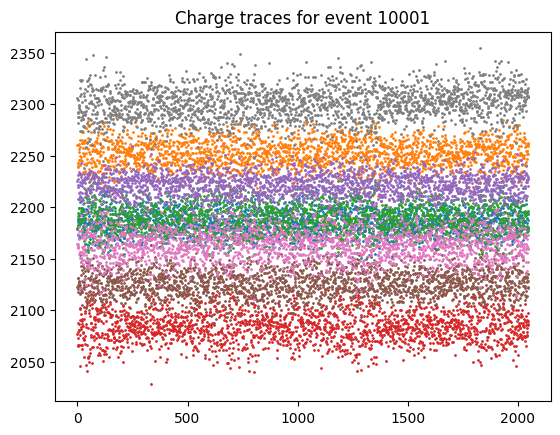

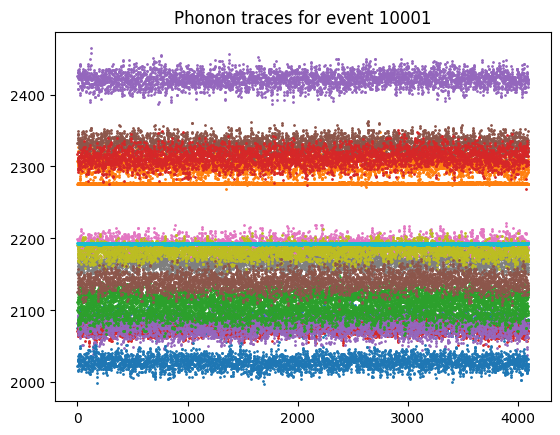

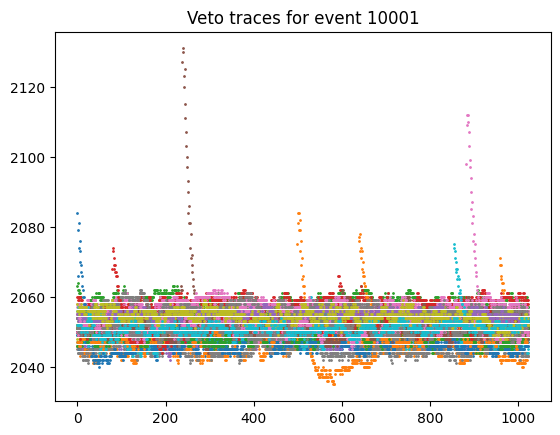

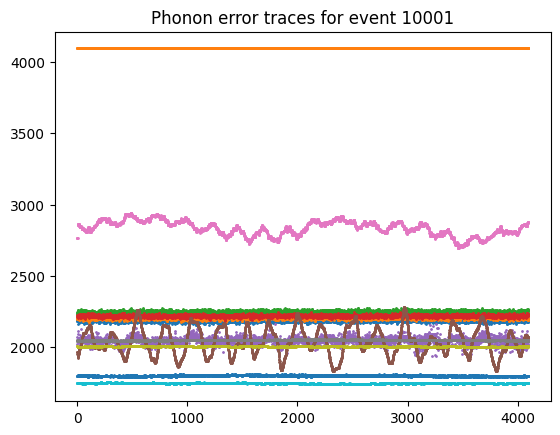

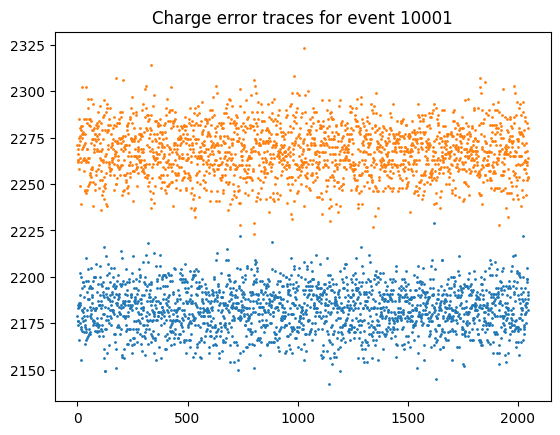

Trace output file created.
Creating cut output file...
Cut output file created.


In [1]:
import sys
sys.path.append('/home/afisher@novateur.com/dataReaderWriter/scdms_soudan/')
import csv_metadata
print('Import successful')

# Path valid from F0001 to F0038
parsed_hdf5_file_path = '/home/afisher@novateur.com/dataReaderWriter/NovateurData/01150212_1819_F0001_parsed.hdf5' #'/data3/afisher/test/parsed_files/01150212_1819_F0001_parsed.hdf5'
trace_output_file_path = '/home/afisher@novateur.com/dataReaderWriter/NovateurData/get_trace_data_test.hdf5'
cut_output_file_path = '/home/afisher@novateur.com/dataReaderWriter/NovateurData/get_cut_data_test.hdf5'

# Load cdms id file
cdms_ids_file_path = '/data3/afisher/cdmslite-run3-cuts-output/ID_CDMSliteR3.csv'


series_number, event_numbers = csv_metadata.get_series_and_event_numbers(parsed_hdf5_file_path)
event_number = event_numbers[0]
print(f'Range of event numbers in file: {event_numbers[0]} to {event_numbers[-1]}')
csv_metadata.get_single_event_metadata(event_number, cdms_ids_file_path, parsed_hdf5_file_path, trace_output_file_path, cut_output_file_path, is_test=False)